# Exploring Cycling in Camden

Seeing as I am around the borough of Camden (in London) a lot due to my attending class at [University College London](http://www.ucl.ac.uk/) and because of the vast number of cyclists I see around me everyday in the area, just for practice I decided to explore some [open data](https://opendata.camden.gov.uk/Transport/Camden-Cycle-Counters/hwk2-xvrv) from two Camden Cycle Counters (which provide accurate and up to date counts of cyclists travelling in both directions) to see if I could find any patterns in the flow of cycle traffic in the borough. The hope is that the code below is replicable and the reader is able to follow along linearly through the analysis process.

## Import Statements

In [1]:
import os
from urllib.request import urlretrieve

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

## Get Data

In [2]:
#url of data source
URL = 'https://opendata.camden.gov.uk/api/views/hwk2-xvrv/rows.csv?accessType=DOWNLOAD' 

#function to only download data if needed ie. if the user doesn't already have it.
def get_camden_data(filename='Camden.csv', url=URL):
    if not os.path.exists(filename):
        urlretrieve(url, 'Camden.csv')
    """Read the csv file of bike counter data and parse the dates from 
    strings to appropriate European date format."""
    dateparse = lambda x: [pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S') for d in x]
    data = pd.read_csv('Camden.csv')
    data['Last Updated'] = pd.to_datetime(data['Last Updated'], format='%d/%m/%Y %I:%M:%S %p')
    df = data.set_index('Last Updated') #new dataframe with index as Last Updated
    return df

In [3]:
df = get_camden_data()
df.head() #check first few rows of data to see if expected columns are there.

,Site Name,Site Identifier,Hourly Count,Last Count,Total Count,Latest Day,Latest Week,Latest Month,Latest Year,Hour,...,Month,Year,Easting,Northing,Longitude,Latitude,Spatial Accuracy,Location,Last Uploaded,Organisation URI
Last Updated,,,,,,,,,,,,,,,,,,,,,
2016-11-17 17:00:00,Royal College Street,100013432,212,2117.0,1223585.0,No,No,No,Yes,17.0,...,November,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",18/11/2016 08:00:10 AM,http://opendatacommunities.org/id/london-borou...
2016-06-23 11:00:00,Royal College Street,100013432,32,NaN,NaN,No,No,No,Yes,11.0,...,June,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",02/08/2016 03:13:01 PM,http://opendatacommunities.org/id/london-borou...
2016-02-27 11:00:00,Royal College Street,100013432,23,NaN,NaN,No,No,No,No,11.0,...,February,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",02/08/2016 03:13:01 PM,http://opendatacommunities.org/id/london-borou...
2017-01-27 13:00:00,Royal College Street,100013432,55,1671.0,1317359.0,No,No,No,Yes,13.0,...,January,2017,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",28/01/2017 08:00:10 AM,http://opendatacommunities.org/id/london-borou...
2017-04-12 01:00:00,Pancras Road,100024240,9,1878.0,578599.0,No,No,No,Yes,1.0,...,April,2017,529747,183410,-0.13074,51.53469,The approximate location of the cycle counter.,"(51.53469, -0.13074)",13/04/2017 08:00:13 AM,http://opendatacommunities.org/id/london-borou...


## Initial Data Exploration

In [4]:
print (df.index.min()) #print earliest Last Updated date in dataset
print (df.index.max()) #print latest Last Updated date in dataset

2015-07-01 00:00:00
2017-05-21 23:00:00


In [5]:
df['Hourly Count'].describe() #summary stats for the hourly counts of bikes for both cycle counters.

count    33298.000000
mean        48.000120
std         63.667258
min          0.000000
25%          3.000000
50%         28.000000
75%         60.000000
max        546.000000
Name: Hourly Count, dtype: float64

Just from these basic stats we can see that we have 33,298 values of hourly counts from both cycle counters in our dataset - ranging over almost 2 years - with an average of 48 cycles on the road at any given hour. There is a surprising maximum of 546 cycles in a single hour at one point (surprising because it is way above the mean hourly count) - this might be worth investigating further.

In [6]:
df.loc[df['Hourly Count'] == 546] #Check out the day and counter where the maximum cycle count was reached.

,Site Name,Site Identifier,Hourly Count,Last Count,Total Count,Latest Day,Latest Week,Latest Month,Latest Year,Hour,...,Month,Year,Easting,Northing,Longitude,Latitude,Spatial Accuracy,Location,Last Uploaded,Organisation URI
Last Updated,,,,,,,,,,,,,,,,,,,,,
2017-05-06 12:00:00,Pancras Road,100024240,546,1381.0,613685.0,No,No,Yes,Yes,12.0,...,May,2017,529747,183410,-0.13074,51.53469,The approximate location of the cycle counter.,"(51.53469, -0.13074)",07/05/2017 08:00:14 AM,http://opendatacommunities.org/id/london-borou...


Looking at the above date that encountered the maximum hourly count of cycles and crosschecking [online](https://www.timeout.com/london/things-to-do/london-events-calendar) for any special events on that day, it appears that there isn't anything extraordinary going on that day. This prompts me to check if there exist other such high hourly counts throughout the dataset.

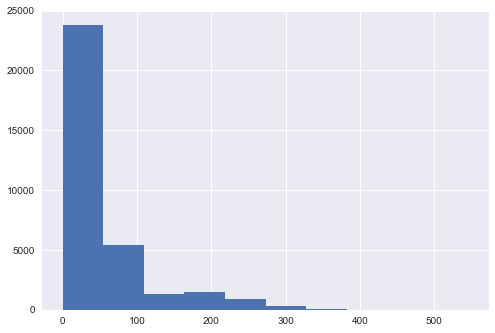

In [7]:
df['Hourly Count'].hist() #plot histogram of hourly counts throughout the dataset

Looking at the histogram above, we can see that the majority of hourly counts are between 0 and 100, which is expected as the average is only 48. We do see however, that there are a quite a few (relatively) days where the hourly count has surpassed 300. Just to get a quick look at the data points that are in this stratospheric range may help to clear up any doubts.

In [8]:
print (df.loc[df['Hourly Count'] > 300].shape) #See the number of data points that had hourly counts above 300
df.loc[df['Hourly Count'] > 300].head() #See some of the days that has hourly counts greater than 300

(163, 23)


,Site Name,Site Identifier,Hourly Count,Last Count,Total Count,Latest Day,Latest Week,Latest Month,Latest Year,Hour,...,Month,Year,Easting,Northing,Longitude,Latitude,Spatial Accuracy,Location,Last Uploaded,Organisation URI
Last Updated,,,,,,,,,,,,,,,,,,,,,
2016-08-31 18:00:00,Royal College Street,100013432,303,2014.0,1092420.0,No,No,No,Yes,18.0,...,August,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",01/09/2016 08:00:09 AM,http://opendatacommunities.org/id/london-borou...
2016-11-17 08:00:00,Royal College Street,100013432,316,2117.0,1223585.0,No,No,No,Yes,8.0,...,November,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",18/11/2016 08:00:10 AM,http://opendatacommunities.org/id/london-borou...
2016-07-19 18:00:00,Royal College Street,100013432,333,NaN,NaN,No,No,No,Yes,18.0,...,July,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",02/08/2016 03:13:01 PM,http://opendatacommunities.org/id/london-borou...
2017-05-06 12:00:00,Pancras Road,100024240,546,1381.0,613685.0,No,No,Yes,Yes,12.0,...,May,2017,529747,183410,-0.13074,51.53469,The approximate location of the cycle counter.,"(51.53469, -0.13074)",07/05/2017 08:00:14 AM,http://opendatacommunities.org/id/london-borou...
2016-07-26 18:00:00,Royal College Street,100013432,307,NaN,NaN,No,No,No,Yes,18.0,...,July,2016,529499,183633,-0.13424,51.53675,The approximate location of the cycle counter.,"(51.53675, -0.13424)",02/08/2016 03:13:01 PM,http://opendatacommunities.org/id/london-borou...


Just visually scanning through the days above where the hourly count surpassed 300, one column in particular struck out to me - Hour. Almost all of the values seem to be either 8.0 (8:00 AM) or 18.0 (18:00 P.M) - values that any Londoner can tell you fall right in the midst of dreaded 'rush hour'. These two time periods - during which the city's masses commute to and from their jobs explains the marked increase in cycle counts during these times on these days. As for the day with the maximum - we see that the hourly count is recorded at mid-day. The educated guess we can make to rationalize this  spike is that there was either a localized event going on during that specific time at Pancras Road or the impending [tube strikes](http://www.cityam.com/263239/another-tube-strike-has-been-set-7-may) had an impact on cycle traffic at the time. 

## Visualizing Hourly Counts over time

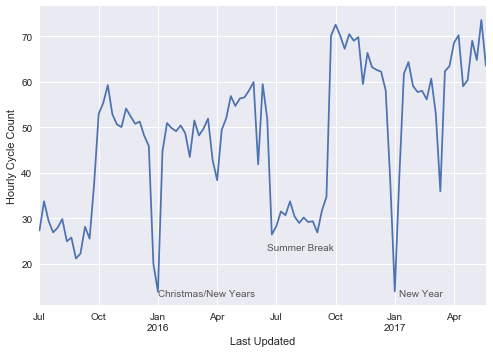

In [9]:
ax = df['Hourly Count'].resample('W').mean().plot() #resample hourly cycle count by week to reduce number of datapoints
ax.set_ylabel("Hourly Cycle Count")

# Add labels to the plot
style = dict(size=10, color='#585858')
ax.text('2016-1-2', 13, "Christmas/New Years", **style)
ax.text('2017-1-2', 13, "New Year", **style)
ax.text('2016-6-15', 23, "Summer Break", **style)

Taking a more longer term look at the hourly cycle counts, we can see that over the course of time that the data has been collected, the overall counts of cyclists on the road has increased (seen by the generally upward trend). There are also only a few dramatic dips in cycling traffic, which predictably fall on major year-end holidays and a slightly prolonged dip during the mid-year summer vacations for schools (as I have labeled on the chart above). 

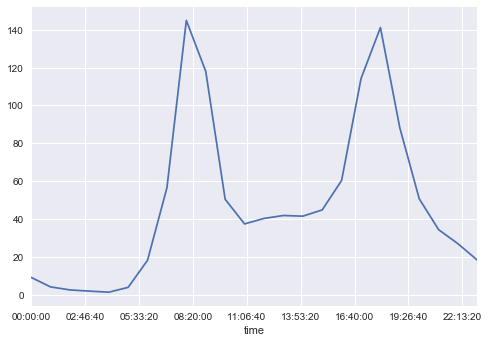

In [10]:
df['Hourly Count'].groupby(df.index.time).mean().plot() #Average hourly counts at each time of day over the dataset

Taking a look at the average hourly counts at each time of day over the course of the dataset, we see that from the above chart that there are generally two major spikes in cycle traffic - predictably during the morning and evening 'rush hour' periods with a lull in the afternoons followed by a significant drop off during the wee hours of the night.

In [11]:
pivoted = df.pivot_table('Hourly Count', index = df.index.time, columns = df.index.date)
pivoted.iloc[:5, :5] #Look at first part of pivoted data

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05
00:00:00,7.5,10.0,10.0,15.5,4.5
01:00:00,1.5,2.5,2.0,2.5,4.0
02:00:00,2.5,1.5,2.5,1.0,1.0
03:00:00,1.0,0.0,0.0,1.0,2.5
04:00:00,1.5,1.0,1.5,1.0,0.0


We now have a two dimensional dataframe where each column is a day in the dataset and each row corresponds to an hour during that day.

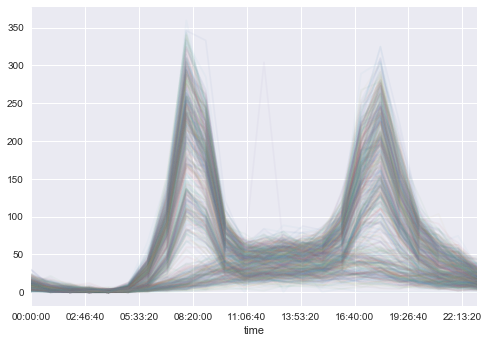

In [12]:
pivoted.plot(legend=False, alpha=0.05) #set opacity of lines to 0.05 allowing for easier visualization

Taking a more granular look at the average hourly cycle counts - in the above chart we have plotted a (fine) line for each day of the year (for the 3 year period of this dataset). We can see that a large portion of days have the bi-modal 'commute' pattern identified earlier with the spikes around the morning and evening rush hours. However, interestingly, we also see days (albeit a fewer number) not following the typical commute pattern with a gentle peak near midday. We can hypothesize that these lines represent the weekend cycle counts (where rush hour isn't a factor).

## Principal Component Analysis

In [13]:
X = pivoted.fillna(0).T.values
X.shape #See total days by number of hours tracked

(691, 24)

We can think of this data now as representing 691 distinct days - each with 24 hours of tracked cycle data. Visualizing 24-dimensional data is quite difficult, so instead we will use a dimensionality reduction technique using [Principal Component Analysis](http://scikit-learn.org/stable/modules/decomposition.html), a fast linear projection which rotates the data such that the projection preserves the maximum variance.

In [14]:
X2 = PCA(2, svd_solver='full').fit_transform(X)
X2.shape #two dimensional projection of the original data

(691, 2)

Now we have a two dimensional projection of our original data.

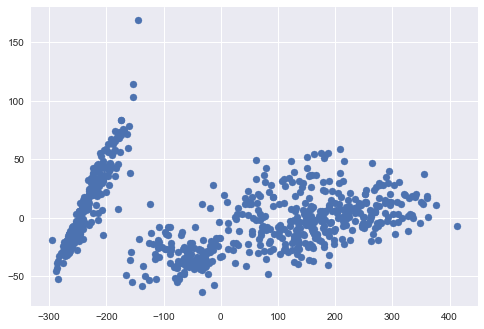

In [15]:
plt.scatter(X2[:, 0], X2[:, 1])

When we do this dimensionality reduction on this dataset, we see that there are two distinct clusters representing different types of days. Let's see if we can automatically identify these clusters.

## Unsupervised Clustering

In [16]:
gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)

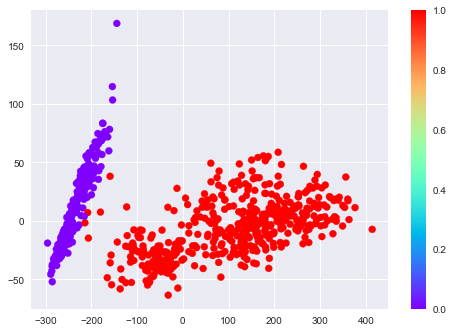

In [17]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow')
plt.colorbar()

Now we can see the partitioning of these two distinct clusters - into red and purple. Now it's worth checking out the commute pattern of just the portion of the data in each of these different clusters of days.

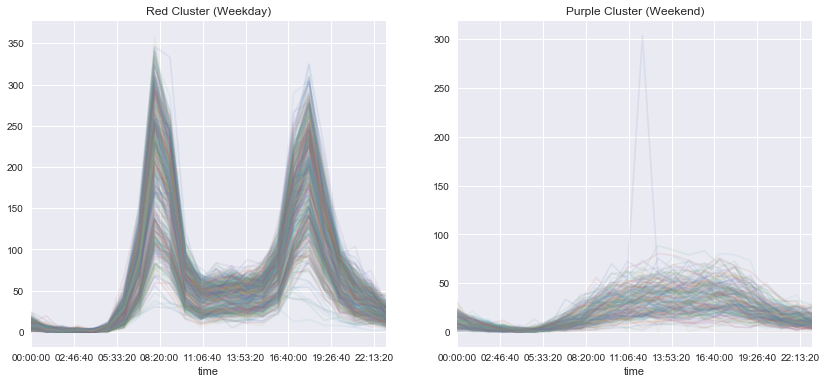

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[0]) #plot red cluster
ax[0].set_title('Red Cluster (Weekday)')
pivoted.T[labels ==0].T.plot(legend=False, alpha=0.1, ax=ax[1]) # plot purple cluster
ax[1].set_title('Purple Cluster (Weekend)')

As seen from the differing patterns of hourly counts above, we have effectively split the red and purple clusters into  a 'weekday' and 'weekend' commute pattern respectively. This makes sense - considering that weekends would definitely have fewer commuters riding on bikes.

## Comparing with day of week

In [19]:
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek #Pivot into day of week with Monday=0 and Sunday=6

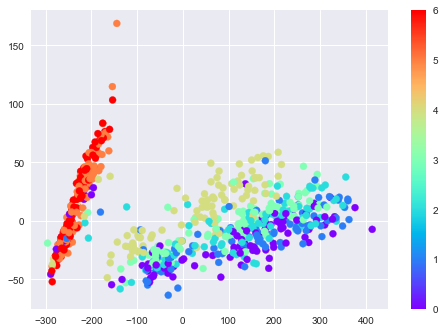

In [20]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow') #plotting with colors based on day of week.
plt.colorbar()

We can see from the day of week clustering above that the majority of days 0, 1, 2, 3, and 4 (Monday, Tuesday, Wednesday, Thursday, and Friday) belong in the cluster at the bottom and days 5 and 6 (Saturday and Sunday) belong to the other cluster. However, what's interesting is that in the predominantly red 'weekend' cluster, we can also see some weekdays interspersed (shown by the purple and light blue points in the red cluster above). Let's see if we can isolate these days to see what was happening.

## Analyzing Outliers

In [22]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 0) & (dayofweek < 5)] #Filter to see only the days that are non-weekends but still fall under the 'weekend' cluster

DatetimeIndex(['2015-08-31', '2015-12-25', '2015-12-28', '2015-12-31',
               '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-02',
               '2016-05-30', '2016-08-29', '2016-12-26', '2016-12-27',
               '2016-12-30', '2017-01-02', '2017-03-09', '2017-04-14',
               '2017-04-17', '2017-05-01'],
              dtype='datetime64[ns]', freq=None)

Filtering on the dates that are in the 'weekend' red cluster but are not really weekends, we can see that that the majority of these outliers are classic [holidays](https://publicholidays.co.uk/) such as Good Friday (2017-04-14), Easter Monday (2017-04-17), and May Day (2017-05-01) which explains their cycling patterns mirroring those of weekends.

## Summary

Wrapping up this data exploration I find it surprising how much can be gleaned from just two cycle counters in a single borough of London. Not only have we managed to find clear patterns in the commuting habits of cyclists (which mirror that of the general city population) but also pinpoint bank holidays and unearth the overall increase of cycling in London as a whole - perhaps lending some credence to the [government initatives](https://www.london.gov.uk/press-releases/mayoral/setting-out-a-vision-for-getting-londoners-active) that aim to get Londoners more active. 